Step 6: Non-stationary demand curves

In [ ]:
#uncertain graph weights (different click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.SWTS_Learner import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.Estimate_click_probabilities import *
from Algorithms.SW_UCB_Learner import SW_UCB
from Algorithms.CD_UCB_Learner import *


In [ ]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce(binary_features=1)
E.set_lambda(0.5)
E.set_products(products)

#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt1 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt1) # optimal configuration: the best combination of arms

In [ ]:
opt1

The initial optimal cumulative expected reward per round is 118.54


In [ ]:
#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []
change = [np.array([1.15,0.95,1.2,0.9,1]) for _ in range(3) ]

for e in range(num_experiments):
    #reset_users_reserv_prices() viene chiamato quando crei env
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    print("Original reservation prices:")
    print(User0.avg_reservation_price)
    print(User1.avg_reservation_price)
    print(User2.avg_reservation_price)
    env.abrupt_change([0,1,2],change)

    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt2 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt2) # optimal configuration: the best combination of arms

## SW-TS (skip it)

In [ ]:
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):
        #if (d==30):
        #    User0.setprice()
        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#

print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

It was not asked, but I wrote it. Unfortunately, it is giving some errors sometimes.

In [ ]:
#Comparison between TS and SW-TS
from Algorithms.SWTS_Learner import *
n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

window_size = 100

swts_rewards_per_experiment = []
ts_rewards_per_experiment = []

swts_pulls_per_arm_per_experiment = []
ts_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)
    swts_learner = SW_TS(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward,env.clicks_current_day, env.purchases_current_day,  env.daily_units)

        pulled_arm = swts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        swts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    swts_rewards_per_experiment.append(swts_learner.collected_rewards)
    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


    swts_pulls_per_arm_per_experiment.append(swts_learner.counter_per_arm)
    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - swts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'b')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

### Simulation in a static environment

In [ ]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

window_size = 90

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

In [ ]:
sw_ucb_rewards_per_experiment

In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - sw_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["SW UCB","UCB"])
plt.show()

Come previsto, SW UCB si comporta peggio di UCB (in un AMBIENTE STATICO).

In [ ]:
#Comparison between SW-UCB and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1  # 0 ?
n_experiments = 10

days_of_change = [100]

window_size = 90

sw_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

sw_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    sw_UCB_learner = SW_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0,1,2],change)
        print(User0.avg_reservation_price)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = sw_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        sw_UCB_learner.update(pulled_arm, reward)

    sw_ucb_rewards_per_experiment.append(sw_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    sw_ucb_pulls_per_arm_per_experiment.append(sw_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

In [ ]:
days_of_change[0]

In [ ]:
sw_ucb_rewards = np.mean(sw_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plot1 = np.concatenate((np.cumsum(opt1-sw_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-sw_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-sw_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["SW UCB","UCB"])
plt.show()

Questa volta SW-UCB si comporta meglio!

In [ ]:
opt1, opt2

## SD1-UCB

In [ ]:
#Comparison between SD1-UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1  # 0 ?
n_experiments = 1

window_size = 100

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
sw_ucb_rewards = np.mean(sw_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plt.plot(np.cumsum(np.mean(opt1 - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt1 - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

In [ ]:
#Comparison between SD1-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 1

window_size = 90

days_of_change = [100]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

cd_rewards_per_day = np.zeros(n_days)
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CD1_UCB(n_arms, window_size)

    for d in range(n_days):
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0,1,2],change)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward)
        cd_rewards_per_day[d] += np.sum(reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


cd_rewards_per_day = ts_rewards_per_day/n_experiments
ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Rewards:")
plt.plot(np.cumsum(np.mean(cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CD1-UCB","UCB"])
plt.show()

In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")

cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plot1 = np.concatenate((np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-cd_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["CD1-UCB","UCB"])
plt.show()

In [ ]:
#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4 * np.log(ucb_learner.t) * np.sum(1 / delta_ucb + 8 * delta_ucb)
empiric_regret_ucb = np.sum(opt - ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_ucb / UPPER_bound_regret_ucb)

In [ ]:
#Theoretical bounds for CD1
delta_cd = opt - cd_rewards_per_day
UPPER_bound_regret_cd = ...
empiric_regret_cd = np.sum(opt - cd_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_cd)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_cd / UPPER_bound_regret_cd)

Usando il secondo algoritmo (CUSUM 2), quello del paper e dei ragazzi

In [ ]:
#Comparison between CU-SUM UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 1

window_size = 90

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms)

    for d in range(n_days):
        print('day ', d)
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        print(pulled_arm)
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm,)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB", "UCB"])
plt.show()

In [ ]:
change

In [ ]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 1

M = 20

days_of_change = [100]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

cd_rewards_per_day = np.zeros(n_days)
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, M,eps=0.1, h=20)

    for d in range(n_days):
        print('--------day--------', d)
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0,1,2],change)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)
        cd_rewards_per_day[d] += np.sum(reward)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)


cd_rewards_per_day = ts_rewards_per_day/n_experiments
ucb_rewards_per_day = ucb_rewards_per_day/n_experiments


In [ ]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regrets")

cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plot1 = np.concatenate((np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-cd_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["CUSUM-UCB","UCB"])
plt.show()

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - down")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - up")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - down")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - up")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - down")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - up")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - down")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - up")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - down")

In [ ]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - up")

In [ ]:
plt.figure(0)
plt.xlabel("t")

cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plot1 = np.concatenate((np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-cd_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["CUSUM-UCB","UCB"])
plt.show()

In [ ]:
#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4 * np.log(ucb_learner.t) * np.sum(1 / delta_ucb + 8 * delta_ucb)
empiric_regret_ucb = np.sum(opt - ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_ucb / UPPER_bound_regret_ucb)

#Theoretical bounds for CUSUM
delta_cd = opt - cd_rewards_per_day
UPPER_bound_regret_cd = ...
empiric_regret_cd = np.sum(opt - cd_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_cd)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_cd / UPPER_bound_regret_cd)

day  0
[0 0 0 0 0]
pulled arm: [0 0 0 0 0]
running CUSUM algorithm on product 0 arm 0
troppo presto
running CUSUM algorithm on product 1 arm 0
troppo presto
running CUSUM algorithm on product 2 arm 0
troppo presto
running CUSUM algorithm on product 3 arm 0
troppo presto
running CUSUM algorithm on product 4 arm 0
troppo presto
day  1
[1 1 1 1 1]
pulled arm: [1 1 1 1 1]
running CUSUM algorithm on product 0 arm 1
troppo presto
running CUSUM algorithm on product 1 arm 1
troppo presto
running CUSUM algorithm on product 2 arm 1
troppo presto
running CUSUM algorithm on product 3 arm 1
troppo presto
running CUSUM algorithm on product 4 arm 1
troppo presto
day  2
[2 2 2 2 2]
pulled arm: [2 2 2 2 2]
running CUSUM algorithm on product 0 arm 2
troppo presto
running CUSUM algorithm on product 1 arm 2
troppo presto
running CUSUM algorithm on product 2 arm 2
troppo presto
running CUSUM algorithm on product 3 arm 2
troppo presto
running CUSUM algorithm on product 4 arm 2
troppo presto
day  3
[3 3 3 3 

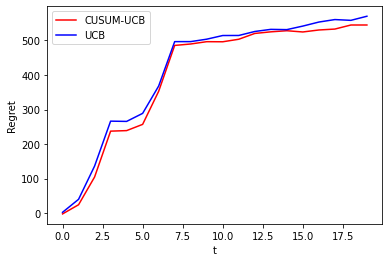

In [16]:
#Comparison between CU-SUM UCB and UCB
# static environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 1

window_size = 90

cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms)

    for d in range(n_days):
        print('day ', d)
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        print(pulled_arm)
        reward = env.round(pulled_arm, )
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm,)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - cd_ucb_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["CUSUM-UCB", "UCB"])
plt.show()

In [211]:
change

[array([1.15, 0.95, 1.2 , 0.9 , 1.  ]),
 array([1.15, 0.95, 1.2 , 0.9 , 1.  ]),
 array([1.15, 0.95, 1.2 , 0.9 , 1.  ])]

In [230]:
#Comparison between CUSUM-UCB and UCB
# dynamic environment

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 1

M = 20

days_of_change = [100]


cd_ucb_rewards_per_experiment = []
ucb_rewards_per_experiment = []

cd_ucb_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ucb_learner = UCB(n_arms=n_arms)
    cd_UCB_learner = CUSUM_UCB(n_arms, M,eps=0.1, h=20)

    for d in range(n_days):
        print('--------day--------', d)
        for day_of_change in days_of_change:
            if d==day_of_change:
                env.abrupt_change([0,1,2],change)

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)

        pulled_arm = cd_UCB_learner.pull_arm()
        reward = env.round(pulled_arm)
        cd_UCB_learner.update(pulled_arm, reward, env.purchases_current_day,env.clicks_current_day)

    cd_ucb_rewards_per_experiment.append(cd_UCB_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)


    cd_ucb_pulls_per_arm_per_experiment.append(cd_UCB_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

--------day-------- 0
pulled arm: [0 0 0 0 0]
running CUSUM algorithm on product 0 arm 0
troppo presto
running CUSUM algorithm on product 1 arm 0
troppo presto
running CUSUM algorithm on product 2 arm 0
troppo presto
running CUSUM algorithm on product 3 arm 0
troppo presto
running CUSUM algorithm on product 4 arm 0
troppo presto
--------day-------- 1
pulled arm: [1 1 1 1 1]
running CUSUM algorithm on product 0 arm 1
troppo presto
running CUSUM algorithm on product 1 arm 1
troppo presto
running CUSUM algorithm on product 2 arm 1
troppo presto
running CUSUM algorithm on product 3 arm 1
troppo presto
running CUSUM algorithm on product 4 arm 1
troppo presto
--------day-------- 2
pulled arm: [2 2 2 2 2]
running CUSUM algorithm on product 0 arm 2
troppo presto
running CUSUM algorithm on product 1 arm 2
troppo presto
running CUSUM algorithm on product 2 arm 2
troppo presto
running CUSUM algorithm on product 3 arm 2
troppo presto
running CUSUM algorithm on product 4 arm 2
troppo presto
-------

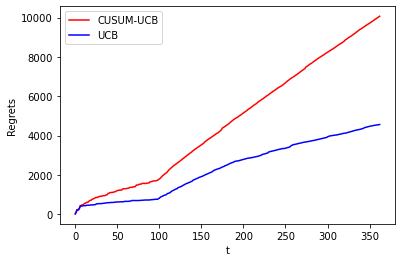

In [231]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regrets")

cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plot1 = np.concatenate((np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-cd_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["CUSUM-UCB","UCB"])
plt.show()

Text(0.5, 1.0, 'product 0 - down')

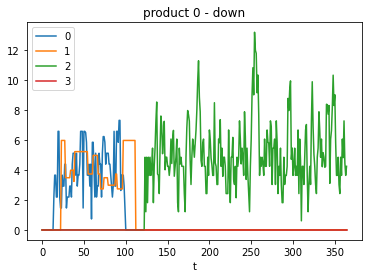

In [232]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - down")

Text(0.5, 1.0, 'product 0 - up')

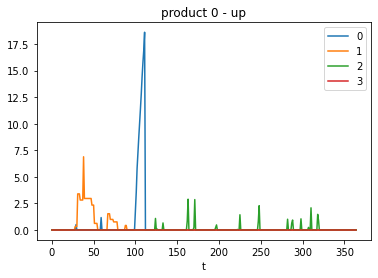

In [233]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[0][arm])
plt.legend([0,1,2,3])
plt.title("product 0 - up")

Text(0.5, 1.0, 'product 1 - down')

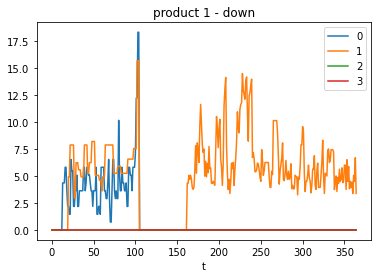

In [234]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - down")

Text(0.5, 1.0, 'product 1 - up')

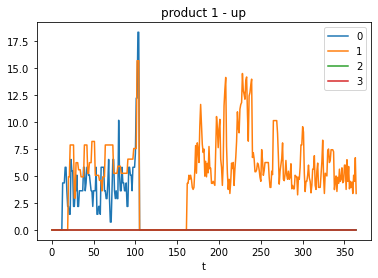

In [235]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[1][arm])
plt.legend([0,1,2,3])
plt.title("product 1 - up")

Text(0.5, 1.0, 'product 2 - down')

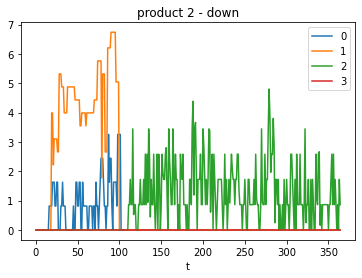

In [236]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - down")

Text(0.5, 1.0, 'product 2 - up')

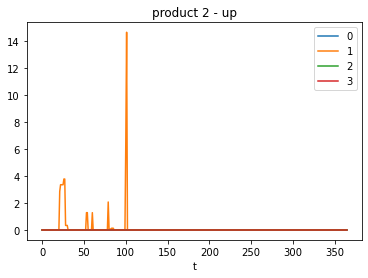

In [237]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[2][arm])
plt.legend([0,1,2,3])
plt.title("product 2 - up")

Text(0.5, 1.0, 'product 3 - down')

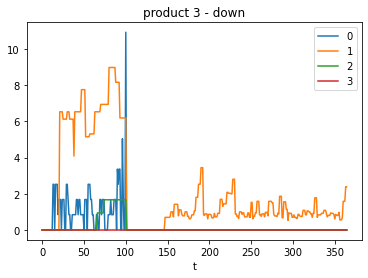

In [238]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - down")

Text(0.5, 1.0, 'product 3 - up')

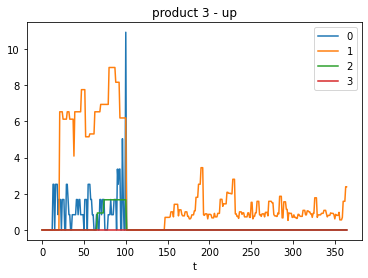

In [239]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[3][arm])
plt.legend([0,1,2,3])
plt.title("product 3 - up")

Text(0.5, 1.0, 'product 4 - down')

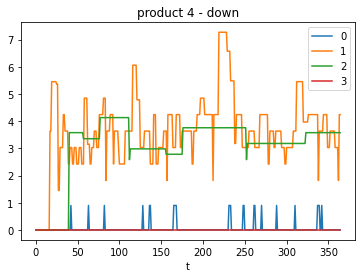

In [240]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.down[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - down")

Text(0.5, 1.0, 'product 4 - up')

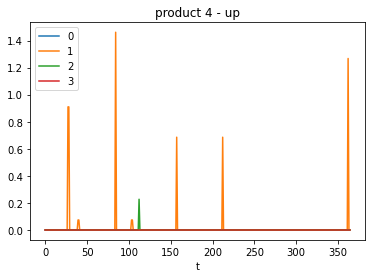

In [241]:
plt.figure(0)
plt.xlabel("t")
for arm in range(4):
    plt.plot(cd_UCB_learner.up[4][arm])
plt.legend([0,1,2,3])
plt.title("product 4 - up")

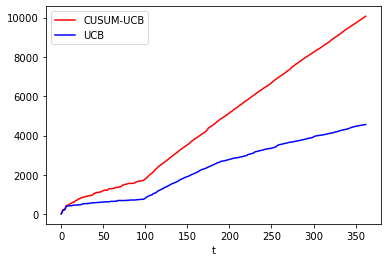

In [242]:
plt.figure(0)
plt.xlabel("t")

cd_ucb_rewards = np.mean(cd_ucb_rewards_per_experiment, axis=0)
ucb_rewards = np.mean(ucb_rewards_per_experiment, axis=0)

plot1 = np.concatenate((np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-cd_ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-cd_ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot1, 'r')
plot2 = np.concatenate((np.cumsum(opt1-ucb_rewards[1:days_of_change[0]]),
                                  (np.cumsum(opt1-ucb_rewards[1:days_of_change[0]+1])[days_of_change[0]-1]+np.cumsum(opt2-ucb_rewards[days_of_change[0]+1:])
                                            )))
plt.plot(plot2, 'b')

plt.legend(["CUSUM-UCB","UCB"])
plt.show()